# Anomaly Detection 
(Core)

*Christina Brockway*

## Task: 

*  Use anomaly detection techniques to detect credit card fraud
*  Stake holder reports that 0.4% of transactions are fraudlent
*  Locate anomalous transactions in data using KMeans and Isolation Forest Models

Using the following data: https://drive.google.com/file/d/18FdD9FzthHNQiYkAsfGS9YDP7EAfDgzp/view?usp=sharing

Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

### Load Data and Imporst

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest 
from scipy.spatial.distance import cdist
from scipy.stats import zscore

from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
df= pd.read_csv("data/credit_card.csv")
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### KMeans:
 - scale data
 - fit KMeans model to create 3 clusters
 - Use random state = 42
 - create matrix of distances between each data point and each cluster
 - define a list using threshold of 99.6%
 - **Optional: PCA to reduce dimesionality to 2 then visualize

#### Scale Data

In [3]:
## Scale data
scaler= StandardScaler()
scaled = scaler.fit_transform(df)

#### Fit data KMeans

In [4]:
#Fit KMeans with 3 clusters, random_state 42
kmeans = KMeans(n_clusters=3, n_init = 'auto', random_state=42)
kmeans.fit(scaled)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [5]:
# add clusters column
df2 = df.copy()
df2['cluster'] = kmeans.predict(scaled)
df2.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,cluster
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,2
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,2


In [6]:
## Save cluster centers
ccenters = pd.DataFrame(kmeans.cluster_centers_, columns = scaled.columns)
ccenters

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.733373,0.614894,0.258886,0.531868,0.219655,0.238605,0.128409,-0.380314,0.343987,0.452917,...,0.132644,0.097765,0.024092,0.099802,0.018579,-0.634795,-0.172748,-0.163275,-0.312725,-0.051803
1,0.350063,-0.280681,-0.018162,-0.114395,-0.090054,-0.017565,-0.214025,0.106396,0.477030,-0.264719,...,-0.092215,-0.099574,-0.111600,0.012146,-0.002878,0.258292,0.243903,-0.044990,0.087200,0.010428
2,-0.025225,0.006732,-0.109574,-0.138477,-0.009073,-0.100062,0.176078,0.071372,-0.708874,0.070121,...,0.037044,0.062828,0.113336,-0.063763,-0.006094,0.028424,-0.187398,0.132547,0.059011,0.014290


#### Create matrix of distance from datapoints to cluster centroids

In [7]:
distances = cdist(scaled, kmeans.cluster_centers_, 'euclidean')

#Save distances as df
cluster_cols = [f'Distance(Cluster {c})' for c in range(len(kmeans.cluster_centers_))]
distancedf = pd.DataFrame(distances, columns = cluster_cols)
distancedf.head()

,Distance(Cluster 0),Distance(Cluster 1),Distance(Cluster 2)
0,4.127849,4.695017,2.825513
1,4.287068,3.583366,2.400110
2,7.190748,7.558619,6.579811
3,5.964779,5.715718,4.714446
4,4.132515,4.825469,3.289179


#### Define a list of the indices of the anomalous data using the threshold given by the stakeholder (99.6% valid).

In [8]:
## Get minimum distance to any cluster for each point
min_dist = np.min(distances, axis=1)
## Set threshold
threshold = np.percentile(min_dist, 99.6)
threshold

20.678582375061943

In [9]:
min_dist[:10]

array([2.82551348, 2.40010997, 6.57981134, 4.71444567, 3.28917859,
       2.15497267, 3.14606241, 7.44322607, 4.58948391, 2.66215283])

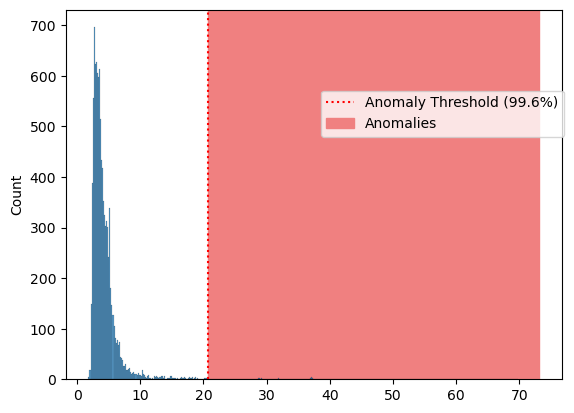

In [10]:
## Visualize threshold
ax = sns.histplot(min_dist)
ax.axvline(threshold, color='red', ls=':', label='Anomaly Threshold (99.6%)')
ax.axvspan(threshold, ax.get_xlim()[1], color='lightcoral',zorder=0, label='Anomalies')
ax.legend(bbox_to_anchor=[.5,.8]);


In [11]:
# Create a filter
km_filter = min_dist > threshold
# Anomalies
km_anomalies = df[km_filter]
km_anomalies

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
159,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,-1.724899,...,7.744222,2.228823,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,3828.04
1376,-3.936794,-3.670519,-1.453820,2.299750,-9.749440,6.456410,10.784088,-2.160016,-0.238116,-1.004398,...,-2.203676,-0.979104,0.957186,2.441960,0.250607,0.300908,1.157867,1.624284,-1.638647,2452.03
1619,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,...,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43
2156,-5.849226,-11.754975,-3.333303,3.673246,-4.459583,0.659098,4.527224,-0.985512,0.237794,-1.854230,...,7.314347,2.160870,-1.992179,-3.240351,0.609619,-0.985548,0.089693,-0.713355,0.653060,3669.00
2212,-5.149638,4.261740,-1.043112,-2.872586,-0.970562,2.037714,-4.472909,-14.892657,1.713550,0.090612,...,-3.235393,14.718212,-4.432106,2.075999,-0.025098,0.042432,-0.045874,0.619351,0.287509,4.00
2439,-12.168192,-15.732974,-0.376474,3.792613,10.658654,-7.465603,-6.907038,1.573722,0.058164,-0.421881,...,4.469095,1.660209,-0.910516,0.010468,-0.097246,-0.329918,0.225916,0.201802,-2.368534,120.00
2594,-2.574940,-2.669331,-3.080133,2.043551,-11.416881,7.885721,12.219249,-1.828209,-1.475925,-1.965803,...,0.828357,-0.115580,0.264090,2.219739,-0.771131,0.145438,-0.240517,1.180441,-0.623651,2909.97
2654,-7.546256,3.051033,-0.524684,1.005228,0.040486,2.751676,-6.267406,-19.176657,1.049976,0.521925,...,-3.785808,9.639417,-3.053597,2.648404,0.429294,0.300704,-0.273082,1.300662,-0.641413,29.90
2756,-10.780565,-9.940571,1.703409,3.094958,7.929119,-4.032777,-8.945496,-5.099389,2.297646,-0.234243,...,-4.829446,-4.399837,1.633000,-0.711629,0.645921,-0.549247,0.704801,3.372603,-1.307732,85.00
2911,-4.344234,4.268511,-1.580163,0.272536,-1.419244,2.603639,-11.164794,-23.632502,-1.849347,-5.217814,...,5.851381,-11.273890,3.661957,-0.200435,0.920605,0.619883,-0.381170,-0.132891,0.539894,1.00


## Isolation Forest
-  NOTE: be sure to exclude additional columns
-  Instantiate and fit and IsolationForest
-  Use contamination value based on the threshold given by Stakeholder(0.004)
-  Define a list of indices of anomalous data

In [12]:
# Instantiate the model with a contaimination of 0.05 (we will identify 5% as anamolous)
isofor = IsolationForest(contamination=0.004, random_state = 42)
# fit the model using .values to avoid a warning
isofor.fit(df.values)

IsolationForest(contamination=0.004, random_state=42)

In [13]:
# Obtain results from the model
predictions = isofor.predict(df.values)
predictions[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
# Create a filter
iso_filter = predictions == -1
# Anomalies
iso_anomalies = df[iso_filter]
iso_anomalies

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
159,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,-1.724899,...,7.744222,2.228823,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,3828.04
1619,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,...,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43
2156,-5.849226,-11.754975,-3.333303,3.673246,-4.459583,0.659098,4.527224,-0.985512,0.237794,-1.854230,...,7.314347,2.160870,-1.992179,-3.240351,0.609619,-0.985548,0.089693,-0.713355,0.653060,3669.00
2756,-10.780565,-9.940571,1.703409,3.094958,7.929119,-4.032777,-8.945496,-5.099389,2.297646,-0.234243,...,-4.829446,-4.399837,1.633000,-0.711629,0.645921,-0.549247,0.704801,3.372603,-1.307732,85.00
2858,-4.508547,5.050932,-2.114599,0.265771,1.263230,0.474670,-3.704011,-12.668590,0.344009,-0.674270,...,-2.574071,12.194849,-4.266839,0.500497,-0.100951,-0.265935,-0.472904,1.055836,0.504921,2.29
2914,-5.390190,5.141127,-2.456760,-1.433851,-2.132299,2.693505,-9.704282,-23.179640,-1.747019,-6.042641,...,5.580590,-11.102491,4.359627,1.943902,0.778397,-0.705948,-1.005957,-0.016154,0.522824,1.00
2917,-5.948482,5.573239,-2.932061,-1.450307,-2.521964,2.641657,-10.045540,-22.746370,-1.726559,-5.962109,...,5.593471,-11.092565,4.327552,2.009214,0.774036,-0.630253,-0.998636,-0.031049,0.518083,7.50
2923,-6.200114,5.025406,-2.742492,-0.940903,-6.656259,5.432294,-9.198175,-22.588547,-3.244295,-5.453339,...,4.592909,-11.235266,4.393846,1.943002,0.846005,-1.343379,-0.707634,-0.210219,0.066529,544.62
5303,-8.733429,-5.681953,2.253879,3.930311,-0.916149,4.355297,5.400286,-4.994383,6.819787,6.764860,...,-5.571503,-2.626882,1.525158,-1.428302,-0.030181,-0.029485,-0.264455,-7.976100,4.712560,553.60
5412,-8.053149,7.045990,-1.102994,-0.870690,-1.360528,4.754590,-7.669995,-23.464595,3.056101,2.085637,...,-4.578147,22.565680,-8.420246,3.511462,-0.526480,0.276928,0.207147,1.180975,0.194628,5.49


## Compare the list of anomalies from KMeans and Isolation Forest. 

In [15]:
## Find where models agree on an anomaly 
anomalies = iso_filter & km_filter
#aa = isofor[anomalies]




In [16]:
## Count how many they agree on

print(f' The number of anomolies detected by Isolation Forest is {len(iso_anomalies)}')
print(f' The number of anomolies detected by KMeans is {len(km_anomalies)}')


 The number of anomolies detected by Isolation Forest is 40
 The number of anomolies detected by KMeans is 40


***The KMeans and IsolationForest agreed 100%***